In [1]:
import os
import pandas as pd
import numpy as np
from pydataset import data

# evaluate
from sklearn.metrics import mean_squared_error
from math import sqrt 

# modules
import env
import acquire as a
import prepare as p
import wrangle as w

#visual imports
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#model methods
import statsmodels.api as sm
from statsmodels.tsa.api import Holt, ExponentialSmoothing

from env import username, host, password
import requests
from datetime import datetime

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('GlobalLandTemperaturesByMajorCity.csv')
df.head()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1849-01-01,26.704,1.435,Abidjan,Côte D'Ivoire,5.63N,3.23W
1,1849-02-01,27.434,1.362,Abidjan,Côte D'Ivoire,5.63N,3.23W
2,1849-03-01,28.101,1.612,Abidjan,Côte D'Ivoire,5.63N,3.23W
3,1849-04-01,26.140,1.387,Abidjan,Côte D'Ivoire,5.63N,3.23W
4,1849-05-01,25.427,1.200,Abidjan,Côte D'Ivoire,5.63N,3.23W


In [3]:
df.City.unique()

array(['Abidjan', 'Addis Abeba', 'Ahmadabad', 'Aleppo', 'Alexandria',
       'Ankara', 'Baghdad', 'Bangalore', 'Bangkok', 'Belo Horizonte',
       'Berlin', 'Bogotá', 'Bombay', 'Brasília', 'Cairo', 'Calcutta',
       'Cali', 'Cape Town', 'Casablanca', 'Changchun', 'Chengdu',
       'Chicago', 'Chongqing', 'Dakar', 'Dalian', 'Dar Es Salaam',
       'Delhi', 'Dhaka', 'Durban', 'Faisalabad', 'Fortaleza', 'Gizeh',
       'Guangzhou', 'Harare', 'Harbin', 'Ho Chi Minh City', 'Hyderabad',
       'Ibadan', 'Istanbul', 'Izmir', 'Jaipur', 'Jakarta', 'Jiddah',
       'Jinan', 'Kabul', 'Kano', 'Kanpur', 'Karachi', 'Kiev', 'Kinshasa',
       'Lagos', 'Lahore', 'Lakhnau', 'Lima', 'London', 'Los Angeles',
       'Luanda', 'Madras', 'Madrid', 'Manila', 'Mashhad', 'Melbourne',
       'Mexico', 'Mogadishu', 'Montreal', 'Moscow', 'Nagoya', 'Nagpur',
       'Nairobi', 'Nanjing', 'New Delhi', 'New York', 'Paris', 'Peking',
       'Pune', 'Rangoon', 'Rio De Janeiro', 'Riyadh', 'Rome', 'São Paulo',
       'S

In [72]:
df.shape

(239177, 7)

# city of Rangoon

In [4]:
# lower case column names
df.columns = df.columns.str.lower()

In [5]:
# subset Rangoon city
rangoon = df[df['city'] == 'Rangoon']

In [6]:
# copy of df
rangoon2 = rangoon.copy()

In [7]:
rangoon.shape

(2613, 7)

In [8]:
rangoon.isna().sum()

dt                                0
averagetemperature               81
averagetemperatureuncertainty    81
city                              0
country                           0
latitude                          0
longitude                         0
dtype: int64

In [9]:
# percentage of nulls 
81/2613

0.030998851894374284

In [10]:
# dropping nulls
rangoon = rangoon.dropna()
rangoon.shape

(2532, 7)

In [11]:
rangoon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2532 entries, 181178 to 183789
Data columns (total 7 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   dt                             2532 non-null   object 
 1   averagetemperature             2532 non-null   float64
 2   averagetemperatureuncertainty  2532 non-null   float64
 3   city                           2532 non-null   object 
 4   country                        2532 non-null   object 
 5   latitude                       2532 non-null   object 
 6   longitude                      2532 non-null   object 
dtypes: float64(2), object(5)
memory usage: 158.2+ KB


In [12]:
rangoon.describe().T

,count,mean,std,min,25%,50%,75%,max
averagetemperature,2532.0,26.735193,1.874158,20.854,25.60750,26.769,27.80225,31.960
averagetemperatureuncertainty,2532.0,0.934210,0.706167,0.125,0.40375,0.682,1.30725,5.806


In [13]:
# rename columns
rangoon = rangoon.rename(columns={'dt': 'date', 'averagetemperature': 'avg_temp',
                                 'averagetemperatureuncertainty':'avg_temp_certainty',
                                 'latitude':'lat','longitude':'lon'})

# covert date to datetime type
rangoon['date'] = pd.to_datetime(rangoon.date)

# set date as index
rangoon = rangoon.set_index('date')

# sort index
rangoon = rangoon.sort_index()

rangoon.head(3)

,avg_temp,avg_temp_certainty,city,country,lat,lon
date,,,,,,
1796-01-01,24.050,2.256,Rangoon,Burma,16.87N,95.44E
1796-02-01,25.371,1.606,Rangoon,Burma,16.87N,95.44E
1796-03-01,27.069,2.168,Rangoon,Burma,16.87N,95.44E


In [14]:
rangoon.index.max(), rangoon.index.min()

(Timestamp('2013-08-01 00:00:00'), Timestamp('1796-01-01 00:00:00'))

In [15]:
rangoon.index.max() - rangoon.index.min()

Timedelta('79470 days 00:00:00')

In [16]:
rangoon.shape

(2532, 6)

In [17]:
# Big time gaps
rangoon.index.year.value_counts()

1796    12
1935    12
1937    12
1938    12
1939    12
        ..
1797    10
1807    10
1832    10
2013     8
1862     3
Name: date, Length: 213, dtype: int64

In [18]:
# change from celsius to farenheit
f = (rangoon.avg_temp * 1.8) + 32

rangoon['avg_temp'] = f

rangoon.head()


,avg_temp,avg_temp_certainty,city,country,lat,lon
date,,,,,,
1796-01-01,75.2900,2.256,Rangoon,Burma,16.87N,95.44E
1796-02-01,77.6678,1.606,Rangoon,Burma,16.87N,95.44E
1796-03-01,80.7242,2.168,Rangoon,Burma,16.87N,95.44E
1796-04-01,85.0946,1.584,Rangoon,Burma,16.87N,95.44E
1796-05-01,84.9758,1.634,Rangoon,Burma,16.87N,95.44E


In [73]:
rangoon.to_csv('rangooncity.csv')

# Split Data

In [19]:
# Percent-Based Split (55/25/20)
train_len = int(0.55 * len(rangoon))
val_test_split = int(0.8 * len(rangoon))
train_len, val_test_split

(1392, 2025)

In [20]:
# Train set. Everything up to train_len
train = rangoon.iloc[:train_len]

# Val set. Everything between train_len & val_test_split
val = rangoon.iloc[train_len:val_test_split]

# Test set. Everything after val_test_split
test = rangoon.iloc[val_test_split:]

train.shape, val.shape, test.shape

((1392, 6), (633, 6), (507, 6))

In [21]:
train.index.max(), val.index.max(), test.index.max()

(Timestamp('1918-08-01 00:00:00'),
 Timestamp('1971-05-01 00:00:00'),
 Timestamp('2013-08-01 00:00:00'))

# Viz over time

In [22]:
train.head()

,avg_temp,avg_temp_certainty,city,country,lat,lon
date,,,,,,
1796-01-01,75.2900,2.256,Rangoon,Burma,16.87N,95.44E
1796-02-01,77.6678,1.606,Rangoon,Burma,16.87N,95.44E
1796-03-01,80.7242,2.168,Rangoon,Burma,16.87N,95.44E
1796-04-01,85.0946,1.584,Rangoon,Burma,16.87N,95.44E
1796-05-01,84.9758,1.634,Rangoon,Burma,16.87N,95.44E


Text(0, 0.5, 'temp(F)')

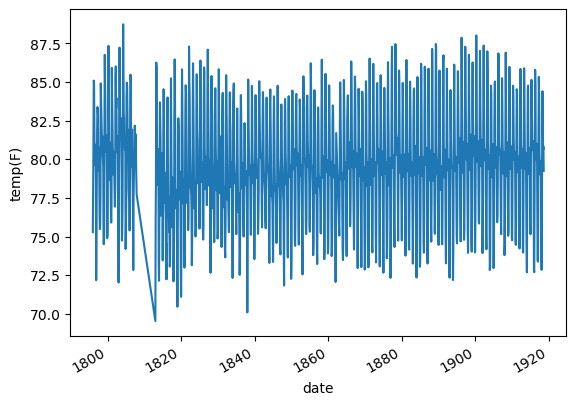

In [23]:
train.avg_temp.plot()
plt.ylabel('temp(F)')

In [24]:
train.avg_temp.min(), train.avg_temp.max()

(69.5372, 88.7414)

<AxesSubplot:xlabel='avg_temp', ylabel='Count'>

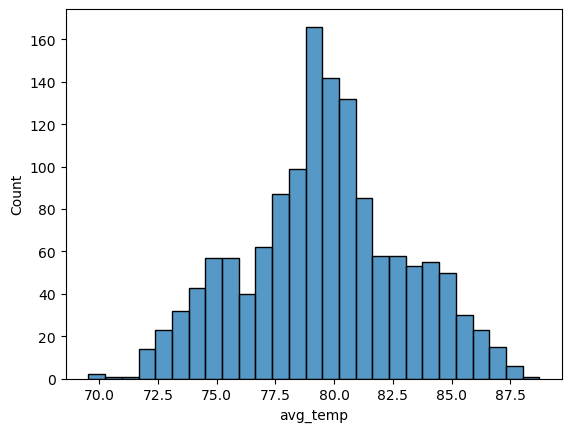

In [25]:
# Distribution of temp
sns.histplot(x='avg_temp', data=train)

**Normal Distribution**

<AxesSubplot:xlabel='Lag', ylabel='Autocorrelation'>

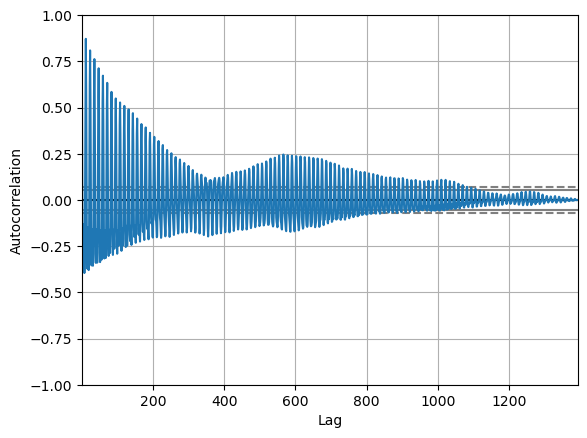

In [26]:
pd.plotting.autocorrelation_plot(train.avg_temp)


<AxesSubplot:xlabel='date'>

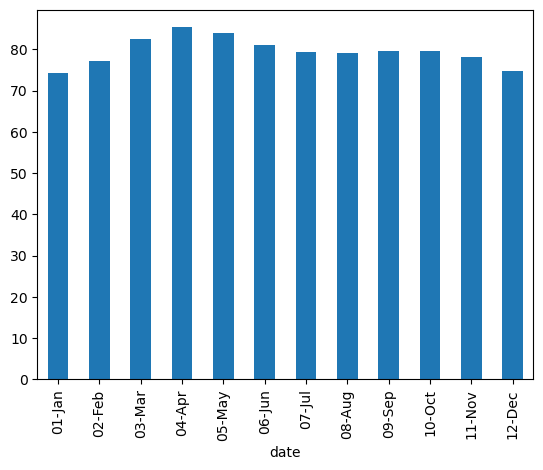

In [27]:
train.avg_temp.groupby(train.avg_temp.index.strftime('%m-%b')).mean().plot.bar()

**Monthly average temperature does not seem to fluctuate drastically, Mid 70s - mid 80s.**

# Modeling

## Previous Cycle

In [28]:
# How to define a cycle with such big time gaps?

In [29]:
# Number of observations per year
train.index.year.value_counts().sort_index()

1796    12
1797    10
1798    10
1799    12
1800    12
1801    10
1802    12
1803    12
1804    12
1805    12
1806    12
1807    10
1813    12
1814    11
1815    12
1816    12
1817    12
1818    12
1819    12
1820    12
1821    12
1822    12
1823    12
1824    12
1825    12
1826    12
1827    12
1828    12
1829    12
1830    12
1831    12
1832    10
1833    12
1834    12
1835    12
1836    12
1837    12
1838    12
1839    12
1840    12
1841    12
1842    12
1843    12
1844    12
1845    12
1846    12
1847    12
1848    12
1849    12
1850    12
1851    12
1852    12
1853    12
1854    12
1855    12
1856    12
1857    12
1858    12
1859    12
1860    12
1861    12
1862     3
1863    12
1864    12
1865    12
1866    12
1867    12
1868    12
1869    12
1870    12
1871    12
1872    12
1873    12
1874    12
1875    12
1876    12
1877    12
1878    12
1879    12
1880    12
1881    12
1882    12
1883    12
1884    12
1885    12
1886    12
1887    12
1888    12
1889    12
1890    12
1891    12

In [30]:
val.index.max()

Timestamp('1971-05-01 00:00:00')

In [31]:
test.index.min()

Timestamp('1971-06-01 00:00:00')

**Predictions to begin on June**

In [32]:
c1 = train[train.index.year == 1917][5:][['avg_temp']]
c1

,avg_temp
date,
1917-06-01,80.5190
1917-07-01,79.6442
1917-08-01,79.6640
1917-09-01,79.0034
1917-10-01,79.8908
1917-11-01,79.2194
1917-12-01,74.8094


In [33]:
c2 = train[train.index.year == 1918][:5][['avg_temp']]
c2

,avg_temp
date,
1918-01-01,72.8492
1918-02-01,75.9002
1918-03-01,81.9662
1918-04-01,84.4088
1918-05-01,82.4558


In [34]:
cycle = pd.concat([c1,c2], axis=0)
cycle

,avg_temp
date,
1917-06-01,80.5190
1917-07-01,79.6442
1917-08-01,79.6640
1917-09-01,79.0034
1917-10-01,79.8908
1917-11-01,79.2194
1917-12-01,74.8094
1918-01-01,72.8492
1918-02-01,75.9002


In [35]:
train[train.index.year >1840]['avg_temp']


date
1841-01-01    76.1684
1841-02-01    77.9774
1841-03-01    83.0660
1841-04-01    85.0586
1841-05-01    83.3360
               ...   
1918-04-01    84.4088
1918-05-01    82.4558
1918-06-01    80.6180
1918-07-01    80.8250
1918-08-01    79.2536
Name: avg_temp, Length: 923, dtype: float64

In [36]:
ten_year_cycle = pd.concat([cycle]*10, ignore_index=True)
ten_year_cycle.shape

(120, 1)

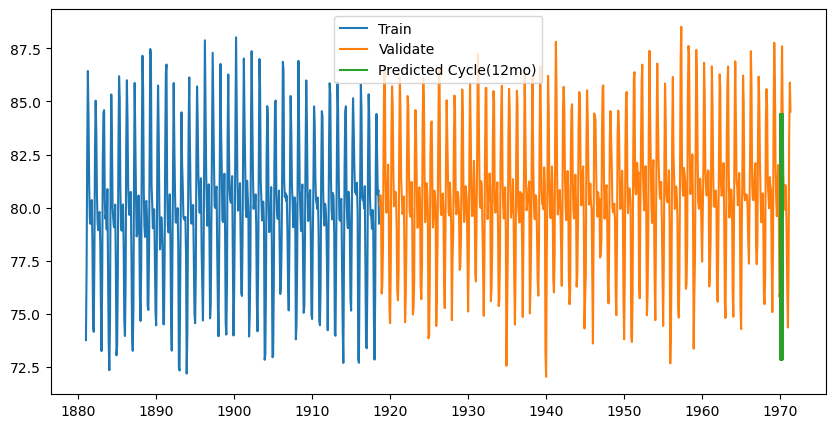

In [37]:
plt.figure(figsize=(10,5))
plt.plot(train[train.index.year >1880]['avg_temp'], label='Train')
plt.plot(val.avg_temp, label='Validate')
plt.plot(ten_year_cycle.avg_temp, label='Predicted Cycle(12mo)' )
plt.legend()


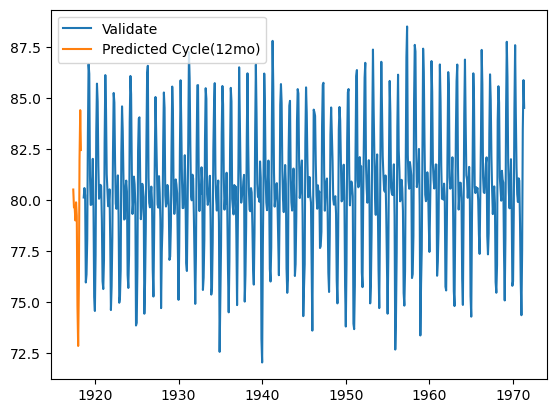

In [38]:
plt.plot(val.avg_temp, label='Validate')
plt.plot(cycle.avg_temp, label='Predicted Cycle(12mo)' )
plt.legend()

In [39]:
# Subset to use for last cycle
train[['avg_temp']][:1390]

,avg_temp
date,
1796-01-01,75.2900
1796-02-01,77.6678
1796-03-01,80.7242
1796-04-01,85.0946
1796-05-01,84.9758
...,...
1918-02-01,75.9002
1918-03-01,81.9662
1918-04-01,84.4088


In [40]:
train.shape, val.shape[0] / 120

((1392, 6), 5.275)

In [41]:
fifetree_year_cycle = pd.concat([cycle]*53, ignore_index=True)
fifetree_year_cycle.shape

(636, 1)

In [42]:
# Making prediction 
fifetree_year_cycle = fifetree_year_cycle.drop(fifetree_year_cycle.tail(3).index)

In [43]:
ten_year_cycle.head()

,avg_temp
0,80.5190
1,79.6442
2,79.6640
3,79.0034
4,79.8908


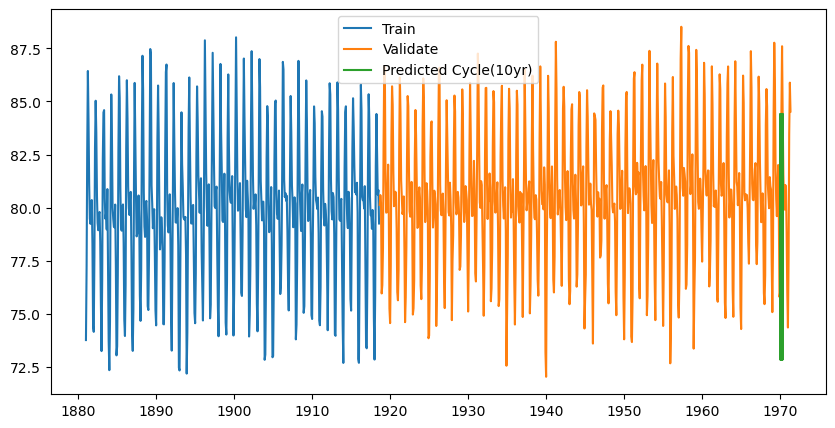

In [44]:
plt.figure(figsize=(10,5))
plt.plot(train[train.index.year >1880]['avg_temp'], label='Train')
plt.plot(val.avg_temp, label='Validate')
plt.plot(ten_year_cycle.avg_temp, label='Predicted Cycle(10yr)',  )
plt.legend()

In [45]:
round(sqrt(mean_squared_error(val['avg_temp'], fifetree_year_cycle['avg_temp'])), 2)

5.7

In [46]:
def regression_errors2(y, yhat):
    '''
    Takes in the target variable and the yhat(predictions) and calulates the SSE, MSE, RMSE, ESS, and TSS regression errors
    '''
    mse = mean_squared_error(y, yhat)
    rmse = mean_squared_error(y, yhat, squared=False)
    sse= mse * len(y)
    ess = yhat-y.mean()
    ess = ess ** 2
    ess = ess.sum()
    tss = ess + sse

    return sse, mse, rmse, ess, tss

In [47]:
sse, mse, rmse, ess, tss = regression_errors2(val['avg_temp'], fifetree_year_cycle['avg_temp'])
print(round(rmse,2))

5.7


In [48]:
# DF of differnet models
compare = pd.DataFrame({'model': 'previous_cycle','rmse_val': [rmse]})
compare

,model,rmse_val
0,previous_cycle,5.703473


# Moving Average

In [49]:
# Rolling average of last 12 months
rolling = train['avg_temp'].rolling(12).mean()[-1]
rolling

79.26665000000001

In [50]:
yhat_df = pd.DataFrame({'avg_temp': rolling}, index= val.index)
yhat_df.head(3)

,avg_temp
date,
1918-09-01,79.26665
1918-10-01,79.26665
1918-11-01,79.26665


In [51]:
yhat_df.shape

(633, 1)

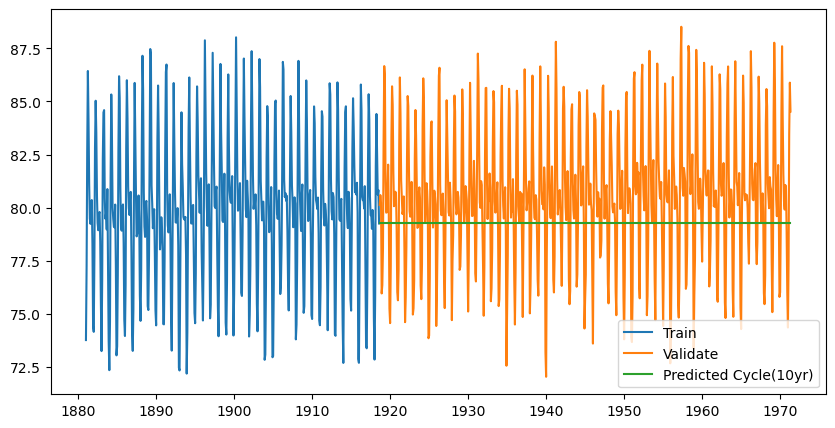

In [52]:
plt.figure(figsize=(10,5))
plt.plot(train[train.index.year >1880]['avg_temp'], label='Train')
plt.plot(val.avg_temp, label='Validate')
plt.plot(yhat_df.avg_temp, label='Predicted Cycle(10yr)',  )
plt.ylabel('Temperature (F)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [53]:
sse, mse, rmse, ess, tss = regression_errors2(val['avg_temp'], yhat_df['avg_temp'])
rmse

3.414861725807683

In [54]:
r_avg_df = pd.DataFrame({'model': 'rolling_avg','rmse_val': [rmse]})

compare = pd.concat([compare, r_avg_df], axis=0)
compare

,model,rmse_val
0,previous_cycle,5.703473
0,rolling_avg,3.414862


# Holts Seasonal

In [55]:
holts_seasonal = ExponentialSmoothing(train.avg_temp, seasonal_periods=633,\
                                      trend='add', seasonal='add', damped=True).fit()

In [56]:
holts_seasonal.params

{'smoothing_level': 0.9999993038853621,
 'smoothing_trend': 2.3338467687809178e-07,
 'smoothing_seasonal': 7.512966118243526e-10,
 'damping_trend': 0.8000497739473029,
 'initial_level': 70.47650658411027,
 'initial_trend': 3.4772988476619853,
 'initial_seasons': array([ 2.03102209,  3.76185502,  2.59181658,  1.64069709,  0.76233891,
         0.20974247,  1.20694785,  2.80686459,  0.90767714, -1.30136741,
        -2.48595624, -3.52127963,  0.93036939,  2.19697177,  1.27442051,
        -1.32269524, -2.69419431, -1.28279964,  0.77016189,  1.27312903,
        -1.08764543, -3.1326527 , -4.01825993, -2.30896058,  1.17710899,
         1.31814499,  0.50376254, -1.19802339, -2.34663694, -1.40239747,
         0.1802806 , -0.83865451, -1.69785127, -3.90340955, -1.87783604,
         0.16458787,  1.59077811,  1.73844358,  0.58983016, -1.28797056,
        -1.61929169, -0.64799259,  0.50659627,  0.25080143, -0.89968446,
        -1.20635325, -1.84225141,  1.33297323,  2.0347902 ,  2.60225691,
        

In [57]:
holts_seasonal.sse

6145.747337930934

In [79]:
d = holts_seasonal.forecast(val.shape[0])

In [84]:
d

1392    75.345831
1393    77.836525
1394    80.469883
1395    83.403632
1396    84.483486
          ...    
2020    82.361806
2021    82.119557
2022    80.959369
2023    80.827337
2024    79.253601
Length: 633, dtype: float64

In [86]:
holts = pd.DataFrame({'avg_temp': d.values}, index=val.index)

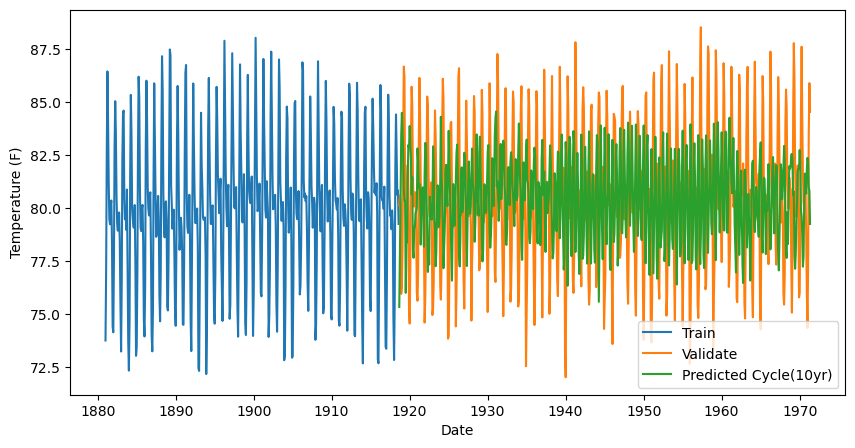

In [89]:
plt.figure(figsize=(10,5))
plt.plot(train[train.index.year >1880]['avg_temp'], label='Train')
plt.plot(val.avg_temp, label='Validate')
plt.plot(holts.avg_temp, label='Predicted Cycle(10yr)',   )
plt.ylabel('Temperature (F)')
plt.xlabel('Date')
plt.legend()
plt.show()

In [59]:
sse, mse, rmse, ess, tss = regression_errors2(val['avg_temp'], holts_seasonal.forecast(val.shape[0]))
rmse

4.535918821196234

In [60]:
a = pd.DataFrame({'model': 'holts_seasonal', 'rmse_val': [rmse]})

In [61]:
compare

,model,rmse_val
0,previous_cycle,5.703473
0,rolling_avg,3.414862


In [62]:
compare = pd.concat([compare, a], axis=0, ignore_index=True)


# Test set. Rolling AVG it is!

In [63]:
rolling_test = test['avg_temp'].rolling(12).mean()[-1]
rolling_test

82.274

In [64]:
test_df = pd.DataFrame({'avg_temp': rolling_test}, index= test.index)
test_df.head(3)

,avg_temp
date,
1971-06-01,82.274
1971-07-01,82.274
1971-08-01,82.274


In [65]:
test_df.shape

(507, 1)

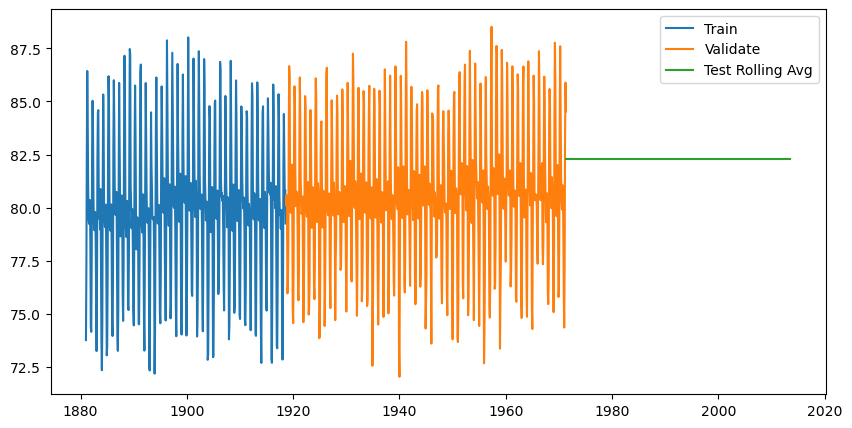

In [66]:
plt.figure(figsize=(10,5))
plt.plot(train[train.index.year >1880]['avg_temp'], label='Train')
plt.plot(val.avg_temp, label='Validate')
plt.plot(test_df.avg_temp, label='Test Rolling Avg')
plt.legend()

In [67]:
rmse_compare_test = pd.DataFrame({'avg_temp': rolling_test}, index= val.index)
rmse_compare_test.shape

(633, 1)

In [68]:
sse, mse, rmse, ess, tss = regression_errors2(val['avg_temp'], rmse_compare_test['avg_temp'])
rmse

3.5847987827486505

In [69]:
a = pd.DataFrame({'model': 'Test_moving_avg', 'rmse_val': [rmse]})

In [70]:
a

,model,rmse_val
0,Test_moving_avg,3.584799


In [71]:
pd.concat([compare,a],axis=0)

,model,rmse_val
0,previous_cycle,5.703473
1,rolling_avg,3.414862
2,holts_seasonal,4.535919
0,Test_moving_avg,3.584799
